In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer



In [126]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

x_train_imputed['DE_GAS_COAL_INTERACTION'] = x_train_imputed['DE_GAS'] * x_train_imputed['DE_COAL']
x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()
x_train_imputed['FR_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_CONSUMPTION'].cumsum()
x_train_imputed['DE_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_CONSUMPTION'].cumsum()
x_test_imputed['GAS_COAL_INTERACTION'] = x_test_imputed['DE_GAS'] * x_test_imputed['DE_COAL']

scaler = StandardScaler()
x_train_scaled= scaler.fit_transform(x_train_imputed)
x_train_imputed = pd.DataFrame(x_train_scaled, columns=x_train_imputed.columns)




In [127]:
x_train_imputed.drop('ID', axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)


In [128]:
#Run baseline model
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)


mse_valid = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, x_train_imputed, y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE : {-np.mean(mae_scores)}')

#Average MSE : 1.3974630165513062
#Average MAE : 0.7273853108405349


Average MSE : 1.3974630165513062
Average MAE : 0.7273853108405349


In [48]:
xgb_reg.fit(x_train_imputed, y_train)
booster = xgb_reg.get_booster()
importance_dict = booster.get_fscore()
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame with sorted feature importances
feature_importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])
print("Feature Importances (Sorted):")
feature_importance_df

Feature Importances (Sorted):


,Feature,Importance
0,DAY_ID,431.0
1,DE_NET_EXPORT_cumsum,282.0
2,DE_CONSUMPTION_cumsum,228.0
3,FR_CONSUMPTION_cumsum,222.0
4,FR_NET_EXPORT_cumsum,219.0
5,DE_CONSUMPTION,216.0
6,COUNTRY_DE,173.0
7,DE_FR_EXCHANGE,114.0
8,FR_CONSUMPTION,106.0
9,CARBON_RET,101.0


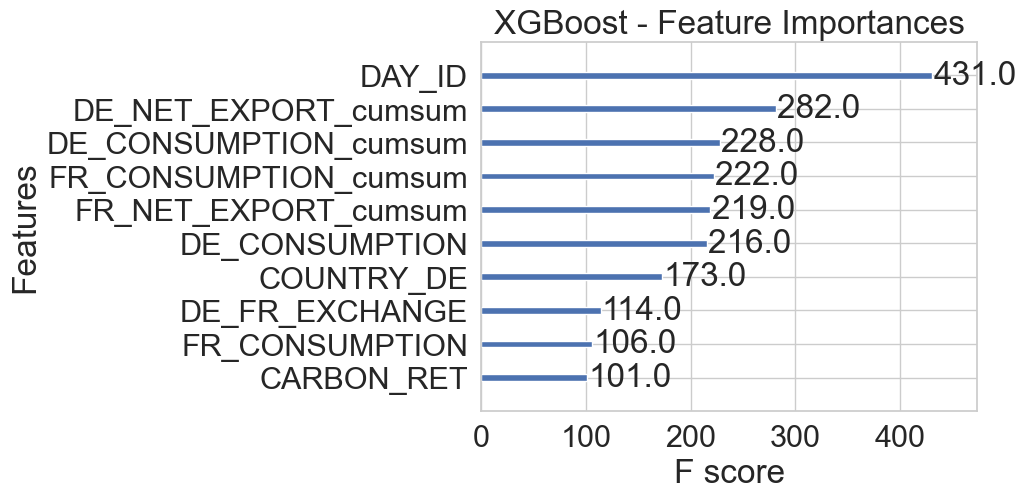

In [49]:
plot_importance(xgb_reg, max_num_features=10)  
plt.title('XGBoost - Feature Importances')
plt.show()

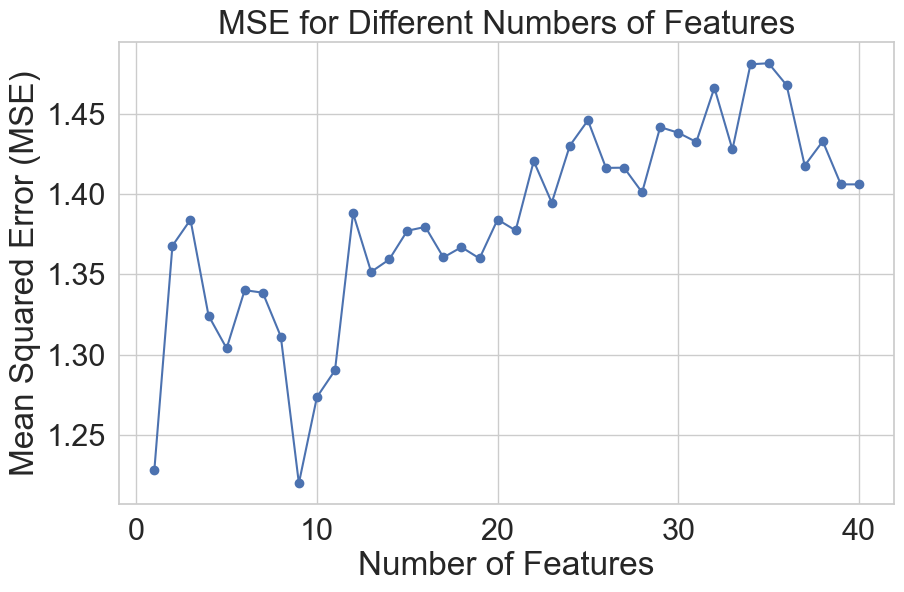

In [50]:
mse_scores_per_k = []

for k in range(1, len(x_train_imputed.columns) + 1):
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    xgb_reg_selected = XGBRegressor(objective='reg:squarederror', random_state=42)

    mse_scores = cross_val_score(xgb_reg_selected, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(x_train_imputed.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

    

In [51]:
#randomized grid search
param_grid = {
    'learning_rate': [0.0001, 0.001,0.01],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [ 4, 5, 6, 7, 8, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}


random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_grid,
    n_iter=80,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

random_search.fit(x_train_imputed, y_train)

print("Best Parameters:", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

mean_cv_score = random_search.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score}')



Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
Mean Cross-Validated Score: 1.0564209997021339


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer



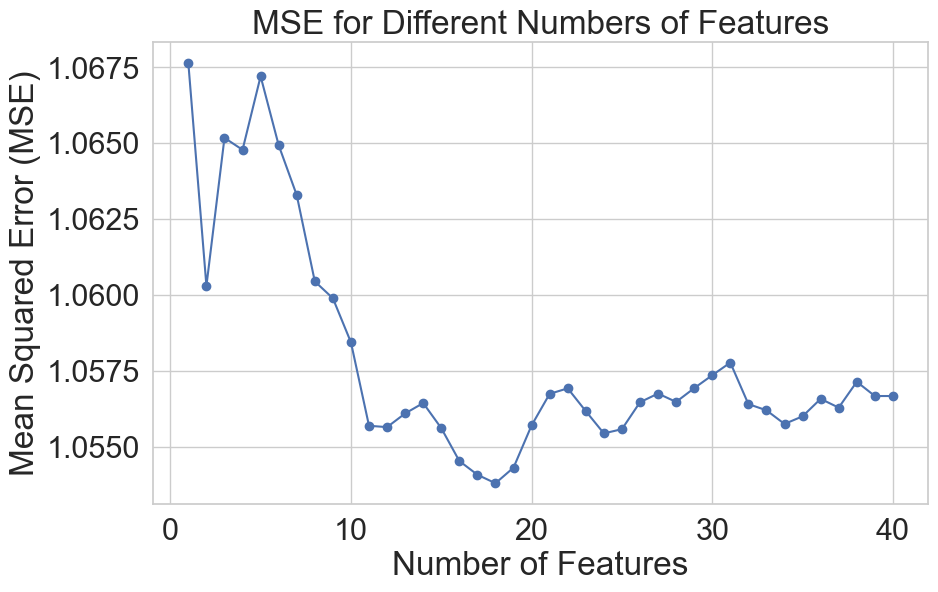

In [53]:
mse_scores_per_k = []

for k in range(1, len(x_train_imputed.columns) + 1):
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    xgb_reg = XGBRegressor(objective='reg:squarederror', subsample= 0.8, n_estimators= 400, max_depth= 9, learning_rate= 0.001, colsample_bytree= 0.8, random_state=42)

    mse_scores = cross_val_score(xgb_reg, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(x_train_imputed.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [54]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,split2_test_score,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,0.8,500,5,0.001,1.0,-0.810685,-1.120062,-0.843352,-1.056421,1
1,0.8,400,9,0.001,0.8,-0.806738,-1.123852,-0.839573,-1.056898,2
2,0.8,400,6,0.001,1.0,-0.812112,-1.118426,-0.841979,-1.056920,3
3,0.8,300,6,0.001,0.9,-0.815895,-1.118676,-0.842022,-1.058394,4
4,0.9,400,6,0.001,1.0,-0.813123,-1.119422,-0.843750,-1.058447,5
5,0.8,300,8,0.001,0.9,-0.813242,-1.120651,-0.840737,-1.058461,6
6,0.8,300,5,0.001,0.9,-0.817688,-1.119081,-0.842428,-1.058474,7
7,0.9,500,6,0.001,1.0,-0.810051,-1.121232,-0.845270,-1.058802,8
8,0.8,300,8,0.001,1.0,-0.813685,-1.121350,-0.840917,-1.058989,9
9,0.8,300,4,0.001,0.8,-0.819288,-1.119801,-0.842550,-1.059125,10


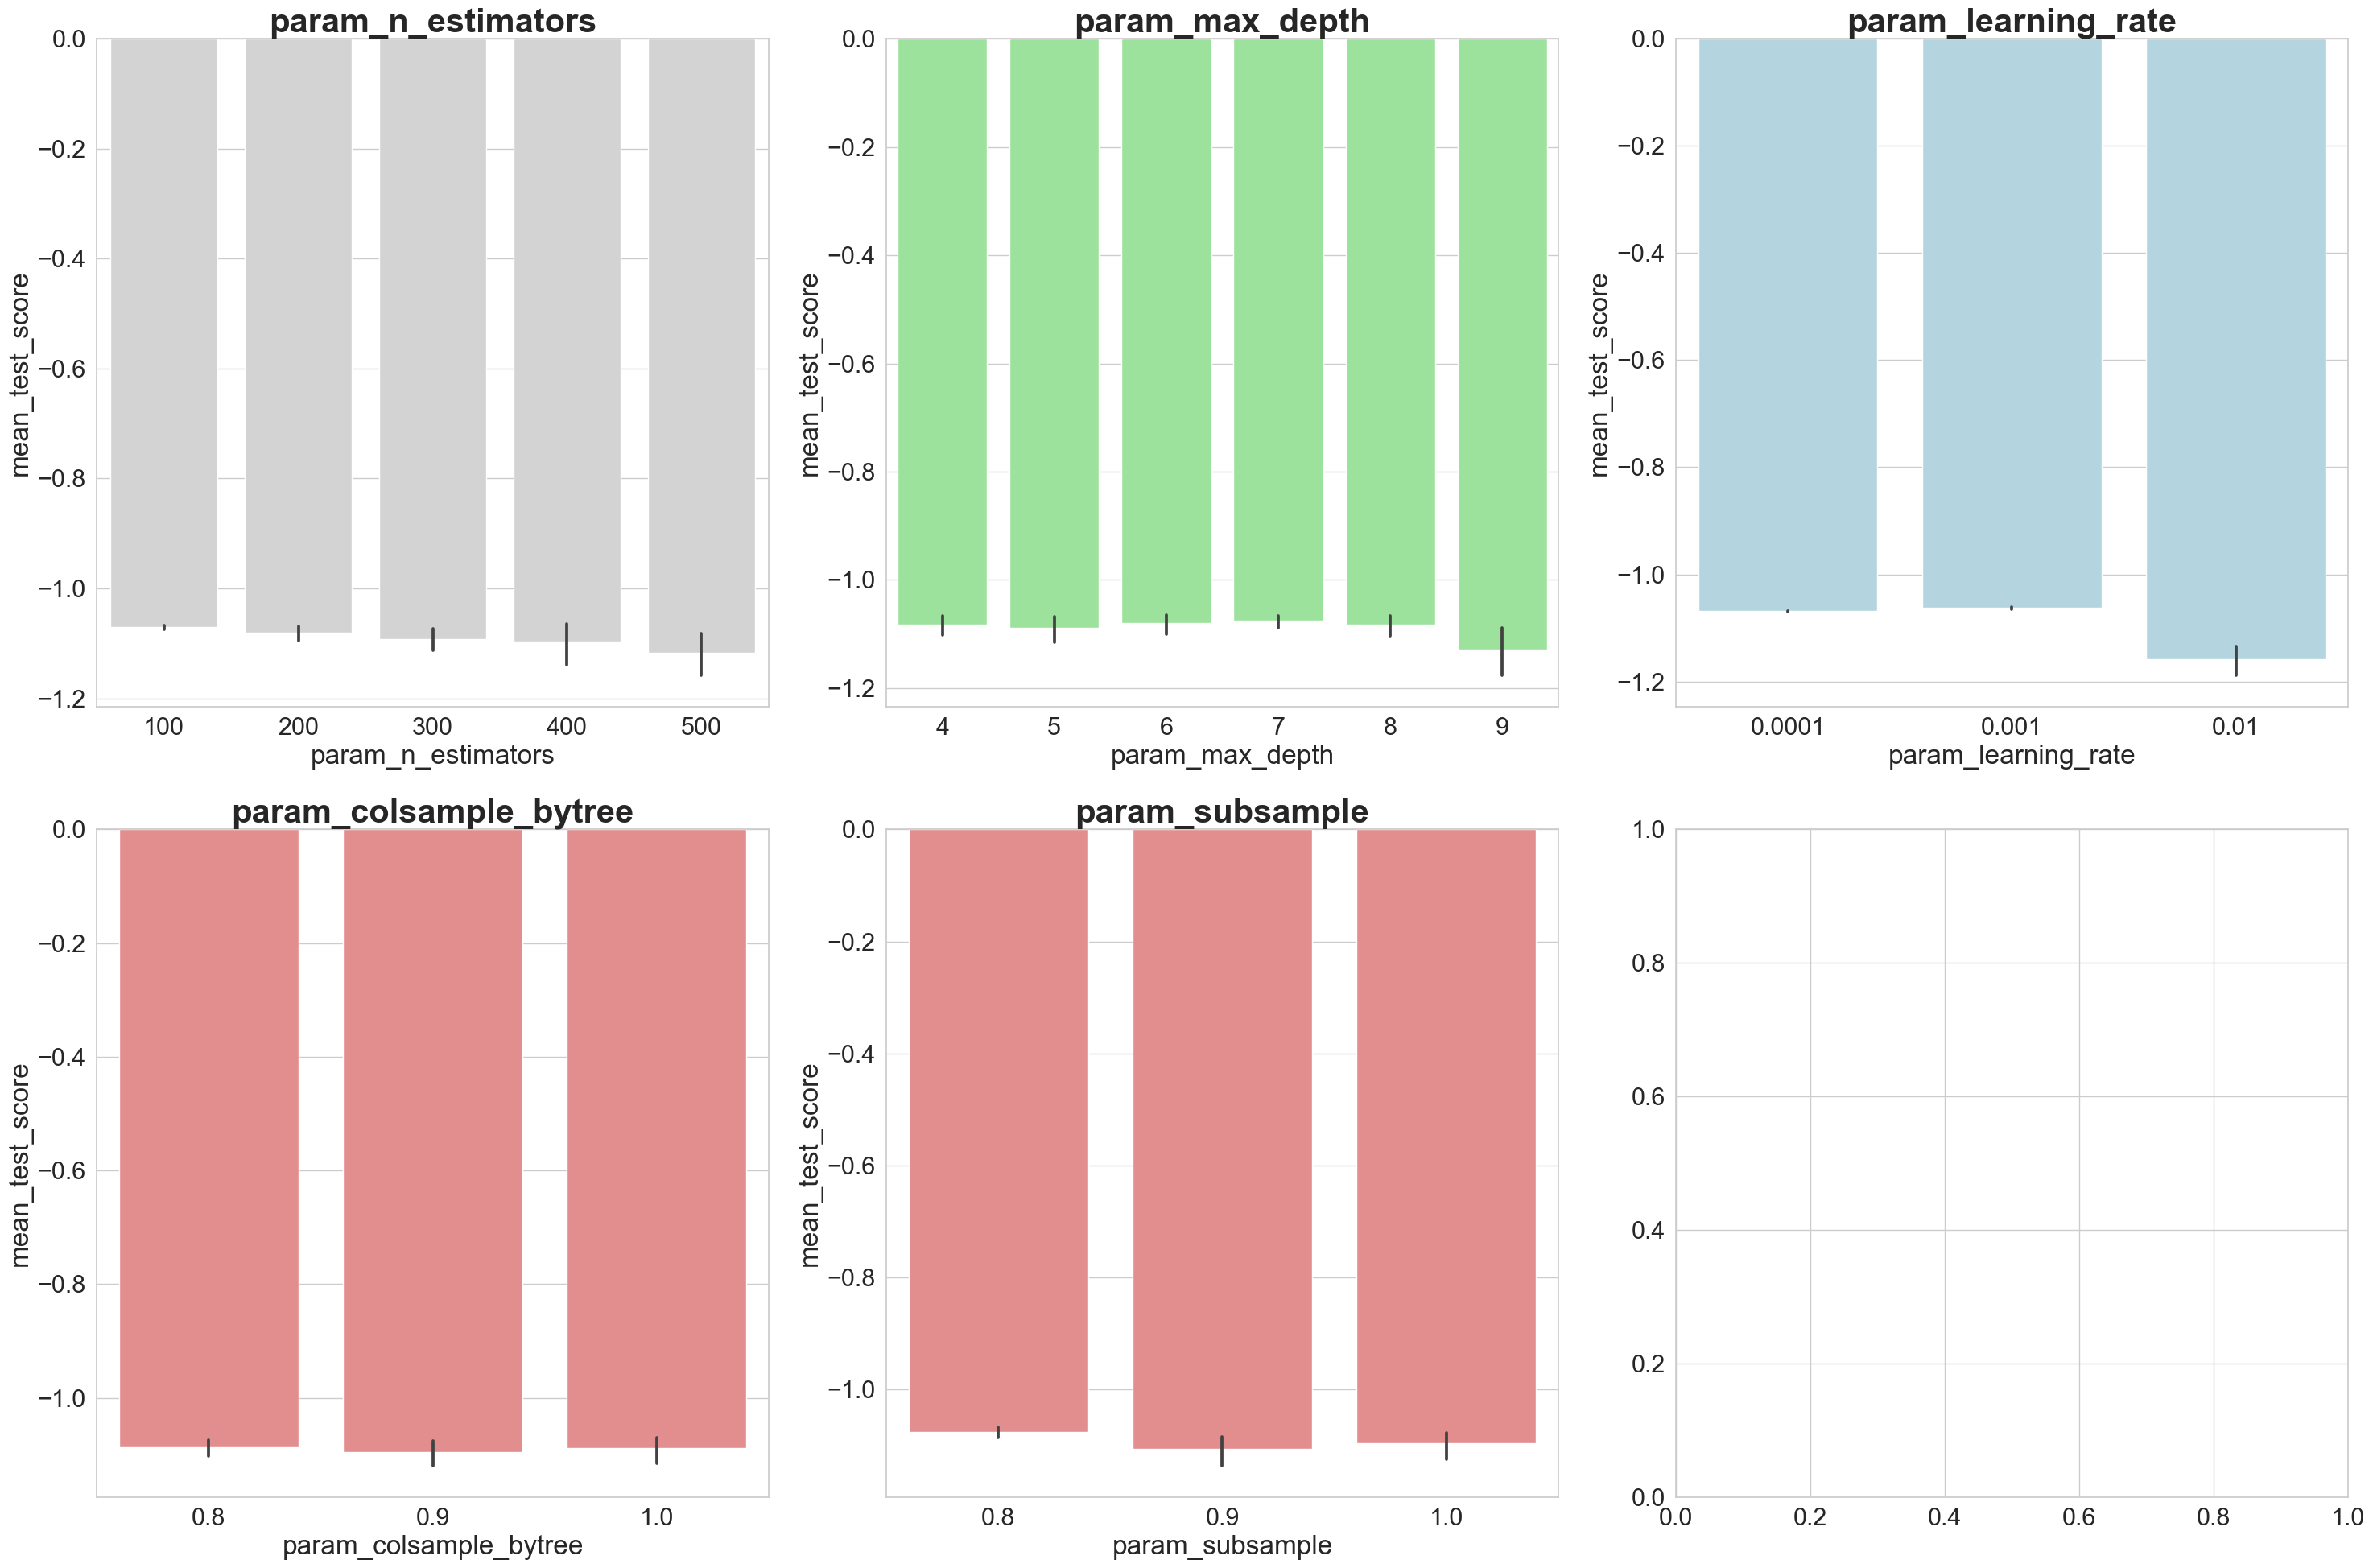

In [55]:
#plot
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig, axs = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(30, 20)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0, 0], color='lightgrey')
axs[0, 0].set_title(label='param_n_estimators', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title(label='param_max_depth', size=30, weight='bold')

sns.barplot(x='param_learning_rate', y='mean_test_score', data=rs_df, ax=axs[0, 2], color='lightblue')
axs[0, 2].set_title(label='param_learning_rate', size=30, weight='bold')

sns.barplot(x='param_colsample_bytree', y='mean_test_score', data=rs_df, ax=axs[1, 0], color='lightcoral')
axs[1, 0].set_title(label='param_colsample_bytree', size=30, weight='bold')

sns.barplot(x='param_subsample', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightcoral')
axs[1, 1].set_title(label='param_subsample', size=30, weight='bold')

plt.tight_layout()
plt.show()

In [57]:
selected_features = [feature[0] for feature in sorted_importances[:18]]

xgb_reg = XGBRegressor(objective='reg:squarederror', subsample= 0.8, n_estimators= 400, max_depth= 9, learning_rate= 0.001, colsample_bytree= 0.8, random_state=42)

mse_valid = cross_val_score(xgb_reg, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, x_train_imputed[selected_features], y_train, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE : {-np.mean(mae_scores)}')

Average MSE : 1.053790607846739
Average MAE : 0.5600591449558763


In [ ]:
#grid search

In [89]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)

# Create a DataFrame with the principal components
columns_pca = [f'PC{i+1}' for i in range(2)]
x_train_pca_df = pd.DataFrame(data=x_train_pca, columns=columns_pca)

x_train_final = pd.concat([x_train_imputed, x_train_pca_df], axis=1)
x_train_final.drop('ID', axis = 1, inplace = True)
